In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy.stats import pearsonr
from adjustText import adjust_text
from statannot import add_stat_annotation
from scipy.stats import ttest_1samp
import sys
import os
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import get_DE_results_long

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
datadir = '../../../../3_expts/processed_data'
de_by_guide = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('./results/DE_donor_robustness_correlation_summary.csv', index_col=0)
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [ ]:
adata_de = ad.read_h5ad(datadir + '/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed=True)
de_donor_robustness = ad.read_h5ad(datadir + '/CD4i_final/CD4i_final.DE_donor_robustness.h5ad', backed=True)

In [4]:
followup_perts = ['MEN1', 'ELOB', 'ARRDC4', 'SGF29', 'GATA3', 'ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'PPCS']

## Plot volcano plot from Perturb-seq

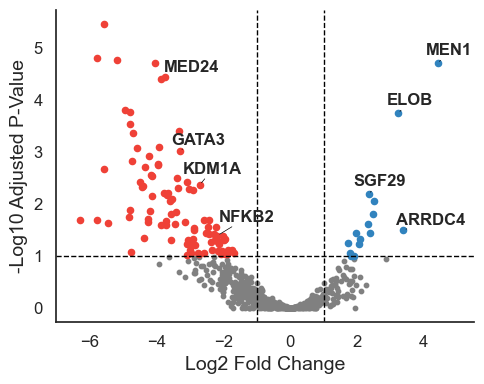

In [152]:
target_gene = 'IL10'
robust_thres = 0.35
adj_p_thres = 0.1
log_fc_thres = 1

obs_mask = (adata_de.obs.target_contrast_gene_name.isin(donor_robustness_summary[(donor_robustness_summary['donor_correlation_min']>robust_thres)&\
    (donor_robustness_summary['condition']=='Stim8hr')]['target_name'].unique()))&(adata_de.obs.culture_condition=='Stim8hr')
var_mask = (adata_de.var.gene_name==target_gene)
log_fc = adata_de[obs_mask, var_mask].layers['log_fc'][:, 0].copy()
adj_pvals = adata_de[obs_mask, var_mask].layers['adj_p_value'][:, 0].copy()
gene_names = adata_de[obs_mask, var_mask].obs['target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Significance mask
is_signif_neg = (adj_pvals < adj_p_thres) & (log_fc > log_fc_thres)
is_signif_pos = (adj_pvals < adj_p_thres) & (log_fc < -log_fc_thres)
sig_log_fc = log_fc[is_signif_neg|is_signif_pos]
sig_pval = adj_pvals[is_signif_neg|is_signif_pos]
sig_names = gene_names[is_signif_neg|is_signif_pos]
sig_neglogp = neg_log10_pval[is_signif_neg|is_signif_pos]

# Get top N significant genes
top_n = 7
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
#annot_genes = np.array(list(set(left_genes)|set(right_genes)|set(['MEN1', 'ELOB', 'ARRDC4', 'SGF29', 'GATA3', 'MED24', 'KDM1A', 'NFKB2'])))
annot_genes = np.array(list(set(['MEN1', 'ELOB', 'ARRDC4', 'SGF29', 'GATA3', 'MED24', 'KDM1A', 'NFKB2'])))

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif_pos], neg_log10_pval[is_signif_pos], c='#ef4137', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')
plt.scatter(log_fc[is_signif_neg], neg_log10_pval[is_signif_neg], c='#3183be', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Reference lines
left_vline_object = plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
right_vline_object = plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
hline_object = plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

lines_to_avoid = [left_vline_object, right_vline_object, hline_object]

plt.xlim([-7,5.5])

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(gene_names == gene)[0][0]
    texts.append(
        plt.text(log_fc[idx], neg_log10_pval[idx], gene,
                 fontsize=12, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts,
            x=log_fc[is_signif_pos|is_signif_neg],
            y=neg_log10_pval[is_signif_pos|is_signif_neg],
            objects=lines_to_avoid,
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)
#plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=12)

sns.despine()
plt.tight_layout()
plt.savefig('./results/IL10_volcano.pdf')
plt.show()

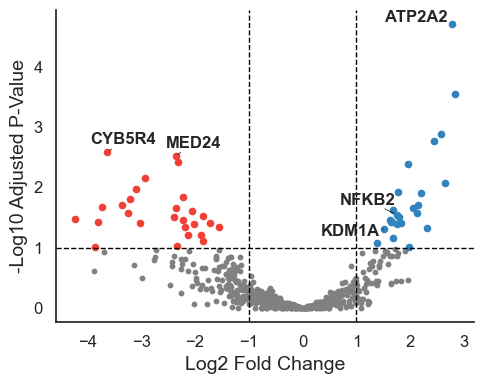

In [154]:
target_gene = 'IL21'
robust_thres = 0.35
adj_p_thres = 0.1
log_fc_thres = 1

obs_mask = (adata_de.obs.target_contrast_gene_name.isin(donor_robustness_summary[(donor_robustness_summary['donor_correlation_min']>robust_thres)&\
    (donor_robustness_summary['condition']=='Stim8hr')]['target_name'].unique()))&(adata_de.obs.culture_condition=='Stim8hr')
var_mask = (adata_de.var.gene_name==target_gene)
log_fc = adata_de[obs_mask, var_mask].layers['log_fc'][:, 0].copy()
adj_pvals = adata_de[obs_mask, var_mask].layers['adj_p_value'][:, 0].copy()
gene_names = adata_de[obs_mask, var_mask].obs['target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Significance mask
is_signif_neg = (adj_pvals < adj_p_thres) & (log_fc > log_fc_thres)
is_signif_pos = (adj_pvals < adj_p_thres) & (log_fc < -log_fc_thres)
sig_log_fc = log_fc[is_signif_neg|is_signif_pos]
sig_pval = adj_pvals[is_signif_neg|is_signif_pos]
sig_names = gene_names[is_signif_neg|is_signif_pos]
sig_neglogp = neg_log10_pval[is_signif_neg|is_signif_pos]

# Get top N significant genes
top_n = 5
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
#annot_genes = np.array(list(set(left_genes)|set(right_genes)|set(['MEN1', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'PPCS'])))
annot_genes = np.array(list(set(['ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2'])))

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif_pos], neg_log10_pval[is_signif_pos], c='#ef4137', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')
plt.scatter(log_fc[is_signif_neg], neg_log10_pval[is_signif_neg], c='#3183be', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Reference lines
left_vline_object = plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
right_vline_object = plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
hline_object = plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

lines_to_avoid = [left_vline_object, right_vline_object, hline_object]

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(gene_names == gene)[0][0]
    texts.append(
        plt.text(log_fc[idx], neg_log10_pval[idx], gene,
                 fontsize=12, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts,
            x=log_fc[is_signif_pos|is_signif_neg],
            y=neg_log10_pval[is_signif_pos|is_signif_neg],
            objects=lines_to_avoid,
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)
#plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig('./results/IL21_volcano.pdf')
plt.show()

## Plot validation experiment results

In [43]:
validation_datadir = '../../../../3_expts/Cell_culture_experiments/IL10_IL21_arrayed_validation/'

In [44]:
df = pd.read_csv(validation_datadir+'IL10_IL21_arrayed_validation.csv')
# Calculate NTC Mean per Donor
ntc = df[df['Perturbation'].str.contains('NTC')][['Donor', 'IL10_perc', 'IL21_perc']]
ntc.columns = ['Donor', 'IL10_NTC_Mean', 'IL21_NTC_Mean']

# Merge means back and calculate Fold Change & Log2 Fold Change
df = df.merge(ntc, on='Donor', how='left')

df['IL10_FC'] = df['IL10_perc'] / df['IL10_NTC_Mean']
df['IL21_FC'] = df['IL21_perc'] / df['IL21_NTC_Mean']

df['IL10_Log2FC'] = np.log2(df['IL10_FC'])
df['IL21_Log2FC'] = np.log2(df['IL21_FC'])

In [45]:
def get_pvalue_annotation(lfc_data, reg_type):
    # Perform one-sample t-test comparing the LFC data to a mean of 0 (Null Hypothesis: mean LFC = 0)
    # The 'nan_policy="omit"' handles missing data gracefully if you have incomplete donor data
    if reg_type=='pos':
        t_stat, p_value = ttest_1samp(lfc_data.dropna(), 0, nan_policy='omit', alternative='less')
    elif reg_type=='neg':
        t_stat, p_value = ttest_1samp(lfc_data.dropna(), 0, nan_policy='omit', alternative='greater')

    # Apply standard asterisk notation
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'ns'

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_13523/3252835412.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)


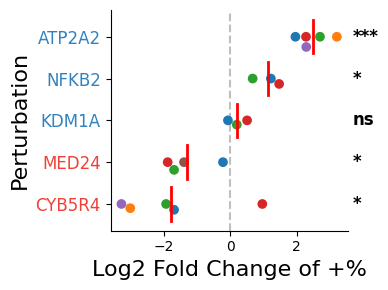

In [46]:
target_gene = 'IL21'
genelist = ['ATP2A2', 'NFKB2', 'KDM1A', 'MED24', 'CYB5R4']
subset = df[df['Perturbation'].isin(genelist)].copy()
subset['Perturbation'] = pd.Categorical(subset['Perturbation'], categories=genelist, ordered=True)
subset = subset.sort_values('Perturbation')

plt.figure(figsize=(4, 3))
ax = sns.swarmplot(data=subset, x=target_gene+'_Log2FC', y='Perturbation', hue='Donor', size=7)
ax.legend_.remove()

# Draw Red Mean Lines
means = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].mean()
for i, gene in enumerate(genelist):
    if gene in means:
        plt.plot([means[gene], means[gene]], [i - 0.4, i + 0.4], color='red', linewidth=2, zorder=5)

plt.axvline(0, color='gray', linestyle='--', alpha=0.5) # Reference line at 0 (no change)
plt.xlabel('Log2 Fold Change')

yticks = ax.get_yticklabels()
colors_blue = '#3183be'
colors_red = '#ef4137'
gene_colors = {
    'ATP2A2': colors_blue,
    'NFKB2': colors_blue,
    'KDM1A': colors_blue,
    'MED24': colors_red,
    'CYB5R4': colors_red
}

# The order of yticks corresponds to the order in geneslist
for i, tick in enumerate(yticks):
    gene_name = genelist[i]
    color = gene_colors.get(gene_name, 'black') # Default to black if gene not found
    tick.set_fontsize(12) # Set a larger font size (adjust as needed)
    tick.set_color(color)

ax.set_yticklabels(yticks)
ax.set_ylabel('Perturbation', fontsize=16)
ax.set_xlabel('Log2 Fold Change of +%', fontsize=16)

gene_reg_type = {
    'ATP2A2': 'neg',
    'NFKB2': 'neg',
    'KDM1A': 'neg',
    'MED24': 'pos',
    'CYB5R4': 'pos'
}

annotations = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].apply(
    # The lambda function receives the Log2FC data (lfc_data) for the current group
    # The group name (gene) is available as lfc_data.name
    lambda lfc_data: get_pvalue_annotation(
        lfc_data, 
        reg_type=gene_reg_type.get(lfc_data.name, 'na') # Use .get() to look up the reg_type
    )
)

y_coords = np.arange(len(genelist))
for i, gene in enumerate(genelist):
    annotation_text = annotations.get(gene, '') 
    max_abs_lfc = subset[subset['Perturbation'] == gene][target_gene+'_Log2FC'].abs().max()
    x_pos_text = max_abs_lfc + 0.05
    x_limit = ax.get_xlim()[1]
    x_pos_text = x_limit + 0.15
    
    # Add the text annotation
    ax.text(x_pos_text, 
            y_coords[i], 
            annotation_text, 
            ha='left', 
            va='center', 
            fontsize=12, 
            weight='bold',
            color='black',
            clip_on=False) # Allow text outside the main plot area

plt.tight_layout()
sns.despine()
plt.savefig('./results/validation_summary_plot'+target_gene+'.pdf')
plt.show()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_13523/1013477415.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)


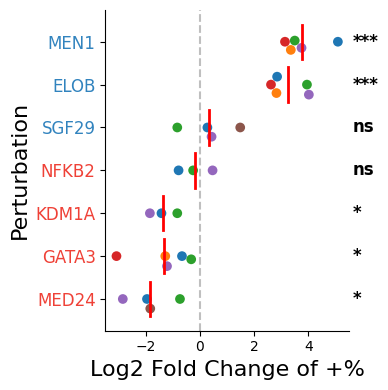

In [47]:
target_gene = 'IL10'
genelist = ['MEN1', 'ELOB', 'SGF29', 'NFKB2', 'KDM1A', 'GATA3', 'MED24']
subset = df[df['Perturbation'].isin(genelist)].copy()
subset['Perturbation'] = pd.Categorical(subset['Perturbation'], categories=genelist, ordered=True)
subset = subset.sort_values('Perturbation')

plt.figure(figsize=(4, 4))
ax = sns.swarmplot(data=subset, x=target_gene+'_Log2FC', y='Perturbation', hue='Donor', size=7)
#ax.set_ylabel('')
ax.legend_.remove()

# Draw Red Mean Lines
means = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].mean()
for i, gene in enumerate(genelist):
    if gene in means:
        plt.plot([means[gene], means[gene]], [i - 0.4, i + 0.4], color='red', linewidth=2, zorder=5)

plt.axvline(0, color='gray', linestyle='--', alpha=0.5) # Reference line at 0 (no change)
plt.xlabel('Log2 Fold Change')

yticks = ax.get_yticklabels()
colors_blue = '#3183be'
colors_red = '#ef4137'
gene_colors = {
    'MEN1': colors_blue,
    'ELOB': colors_blue,
    'SGF29': colors_blue,
    'NFKB2': colors_red,
    'KDM1A': colors_red,
    'GATA3': colors_red,
    'MED24': colors_red,
}

# The order of yticks corresponds to the order in geneslist
for i, tick in enumerate(yticks):
    gene_name = genelist[i]
    color = gene_colors.get(gene_name, 'black') # Default to black if gene not found
    tick.set_fontsize(12) # Set a larger font size (adjust as needed)
    tick.set_color(color)

ax.set_yticklabels(yticks)
ax.set_ylabel('Perturbation', fontsize=16)
ax.set_xlabel('Log2 Fold Change of +%', fontsize=16)

gene_reg_type = {
    'MEN1': 'neg',
    'ELOB': 'neg',
    'SGF29': 'neg',
    'NFKB2': 'pos',
    'KDM1A': 'pos',
    'GATA3': 'pos',
    'MED24': 'pos',
}

annotations = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].apply(
    # The lambda function receives the Log2FC data (lfc_data) for the current group
    # The group name (gene) is available as lfc_data.name
    lambda lfc_data: get_pvalue_annotation(
        lfc_data, 
        reg_type=gene_reg_type.get(lfc_data.name, 'na') # Use .get() to look up the reg_type
    )
)

y_coords = np.arange(len(genelist))
for i, gene in enumerate(genelist):
    annotation_text = annotations.get(gene, '') 
    max_abs_lfc = subset[subset['Perturbation'] == gene][target_gene+'_Log2FC'].abs().max()
    x_pos_text = max_abs_lfc + 0.05
    x_limit = ax.get_xlim()[1]
    x_pos_text = x_limit + 0.15
    
    # Add the text annotation
    ax.text(x_pos_text, 
            y_coords[i], 
            annotation_text, 
            ha='left', 
            va='center', 
            fontsize=12, 
            weight='bold',
            color='black',
            clip_on=False) # Allow text outside the main plot area

plt.tight_layout()
sns.despine()
plt.savefig('./results/validation_summary_plot'+target_gene+'.pdf')
plt.show()

In [48]:
df

,Sample:,IL10_perc,IL21_perc,Donor,Perturbation,Unnamed: 5,Unnamed: 6,IL10_NTC_Mean,IL21_NTC_Mean,IL10_FC,IL21_FC,IL10_Log2FC,IL21_Log2FC
0,CE0007545_NTC.fcs,0.820,5.70,CE0007545,NTC,NaN,NaN,0.82,5.70,1.000000,1.000000,0.000000,0.000000
1,CE0007545_SGF29.fcs,2.300,12.90,CE0007545,SGF29,NaN,NaN,0.82,5.70,2.804878,2.263158,1.487938,1.178337
2,CE0007545_MED24.fcs,0.230,2.16,CE0007545,MED24,NaN,NaN,0.82,5.70,0.280488,0.378947,-1.833990,-1.399931
3,CE0009596_NTC.fcs,0.190,1.56,CE0009596,NTC,NaN,NaN,0.19,1.56,1.000000,1.000000,0.000000,0.000000
4,CE0009596_MEN1.fcs,6.490,2.09,CE0009596,MEN1,NaN,NaN,0.19,1.56,34.157895,1.339744,5.094147,0.421957
5,CE0009596_ELOB.fcs,1.370,1.36,CE0009596,ELOB,NaN,NaN,0.19,1.56,7.210526,0.871795,2.850105,-0.197939
6,CE0009596_ARRDC4.fcs,3.060,2.08,CE0009596,ARRDC4,NaN,NaN,0.19,1.56,16.105263,1.333333,4.009460,0.415037
7,CE0009596_SGF29.fcs,0.230,5.38,CE0009596,SGF29,NaN,NaN,0.19,1.56,1.210526,3.448718,0.275634,1.786060
8,CE0009596_GATA3.fcs,0.120,2.20,CE0009596,GATA3,NaN,NaN,0.19,1.56,0.631579,1.410256,-0.662965,0.495957
9,CE0009596_MED24.fcs,0.049,0.42,CE0009596,MED24,NaN,NaN,0.19,1.56,0.257895,0.269231,-1.955146,-1.893085


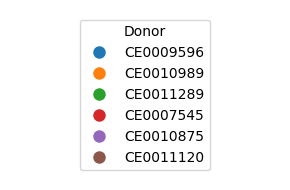

In [49]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the donor colors and labels used in the original swarmplot
# Note: Seaborn/Matplotlib cycles through a default color palette. 
# We'll use the default 'tab10' palette colors that typically correspond to the first four categories.
# If your original plot used a custom palette, you must replace these hex codes.
donor_colors = {
    'CE0009596': '#1f77b4', # Default blue (often first in Matplotlib/Seaborn)
    'CE0010989': '#ff7f0e', # Default orange
    'CE0011289': '#2ca02c', # Default green
    'CE0007545': '#d62728',  # Default red
    'CE0010875': '#9467bd', # Default purple
    'CE0011120': '#8c564b',  # Default brown
}

# Get the labels and colors for the legend
labels = list(donor_colors.keys())
colors = list(donor_colors.values())

# Create a new figure just for the legend
plt.figure(figsize=(3, 2))
ax_legend = plt.gca()

# Manually create Line2D artists for the legend.
# Since the original plot used a swarmplot (scatter-like), we use markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=10)
    for label, color in zip(labels, colors)
]

# Add the legend to the new axes
legend = ax_legend.legend(handles=legend_elements, 
                          title='Donor', 
                          loc='center', 
                          frameon=True)

# Remove the axes lines, ticks, and labels to make it a "standalone" legend
ax_legend.axis('off')

# Increase the font size of the legend title and labels for better visibility
plt.setp(legend.get_title(), fontsize='10') # Adjust title font size
plt.setp(legend.get_texts(), fontsize='10') # Adjust label font size

plt.tight_layout()
plt.savefig('./results/validation_summary_plot_standalone_legend.pdf', bbox_inches='tight')
plt.show()